In [2]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """


In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
data_dir ="/content/gdrive/MyDrive/dataset/photos"



In [6]:
data_dir 



'/content/gdrive/MyDrive/dataset/photos'

In [7]:
import pathlib                        #We have used pathlib in data directory so that we are able to use glob and you can 
data_dir = pathlib.Path(data_dir)      #already see the advantages of glob, when we use pathlib we see tha it is a Windows path 
data_dir                             #We converted our directory to windows pathlib directory

PosixPath('/content/gdrive/MyDrive/dataset/photos')

In [8]:
alzheimer_images_dict = {                                    #here we have created a dictionary, if we do 
    'mild': list(data_dir.glob('MildDemented/*')),           #alzheimer_images_dict[MildDemented] we get all paths of 
    'moderate': list(data_dir.glob('ModerateDemented/*')),   #milddemented
    'no': list(data_dir.glob('NonDemented/*')),
    'verymild': list(data_dir.glob('VeryMildDemented/*')),
  
}

In [9]:
alzheimer_labels_dict = {   #here I am assigning labels to each of the  classes
    'mild': 0,
    'moderate': 1,
    'no': 2,
    'verymild': 3,
    
}

In [10]:
X, y = [], []

for alzheimer_name, images in alzheimer_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(299,299))
        X.append(resized_img)
        y.append(alzheimer_labels_dict[alzheimer_name])
print(X[0].shape)  

(299, 299, 3)


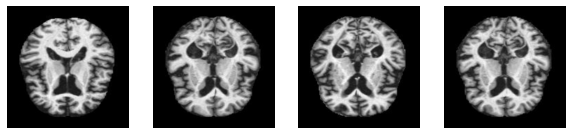

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (299, 299, 3)
Shape of an image in X_test:  (299, 299, 3)


In [13]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [14]:
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (4288, 299, 299, 3)
X_test Shape:  (2112, 299, 299, 3)
y_train Shape:  (4288, 4)
y_test Shape:  (2112, 4)


In [15]:
from keras.applications import xception


img_rows, img_cols = 299, 299 


pretained_model = tf.keras.applications.xception.Xception(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))  #where ever false is there means that they are not going  to trained 
                                                        #again as they are alredy being trained
# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in pretained_model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(pretained_model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

83697664/83683744 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 SeparableConv2D False
8 BatchNormalization False
9 Activation False
10 SeparableConv2D False
11 BatchNormalization False
12 Conv2D False
13 MaxPooling2D False
14 BatchNormalization False
15 Add False
16 Activation False
17 SeparableConv2D False
18 BatchNormalization False
19 Activation False
20 SeparableConv2D False
21 BatchNormalization False
22 Conv2D False
23 MaxPooling2D False
24 BatchNormalization False
25 Add False
26 Activation False
27 SeparableConv2D False
28 BatchNormalization False
29 Activation False
30 SeparableConv2D False
31 BatchNormalization False
32 Conv2D False
33 MaxPooling2D False
34 BatchNormalization False
35 Add False
36 Activation False
37 SeparableConv2D False
38 BatchNormalization False
39 Activation False
40 SeparableConv2D False
41 BatchNormalization Fa

In [16]:
num_classes = 4
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""                      #here I adding extra additional layers that will be helpful 
                                                              #in my program.
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 4

FC_Head = lw(pretained_model, num_classes)   #here you can see I am passing vgg and number of classes to the lw func and lw bottom model
                                 #will be vgg
model = Model(inputs = pretained_model.input, outputs = FC_Head)


In [18]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [19]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [20]:
history = model.fit(X_train,y_train,
                    epochs=100, 
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/5
134/134 [==============================] - 2109s 16s/step - loss: 1.5315 - accuracy: 0.5173 - val_loss: 0.9000 - val_accuracy: 0.5568
Epoch 2/5
134/134 [==============================] - 2078s 16s/step - loss: 0.9007 - accuracy: 0.5606 - val_loss: 0.8841 - val_accuracy: 0.5677
Epoch 3/5
134/134 [==============================] - 2079s 16s/step - loss: 0.8768 - accuracy: 0.5760 - val_loss: 0.8840 - val_accuracy: 0.5696
Epoch 4/5
134/134 [==============================] - 2080s 16s/step - loss: 0.8615 - accuracy: 0.5856 - val_loss: 0.8807 - val_accuracy: 0.5568
Epoch 5/5
134/134 [==============================] - 2098s 16s/step - loss: 0.8362 - accuracy: 0.5970 - val_loss: 0.9219 - val_accuracy: 0.5317


In [21]:
model.save('Xceptionmmf1')

INFO:tensorflow:Assets written to: Xceptionmmf1/assets


In [22]:
model.evaluate(X_test,y_test)

66/66 [==============================] - 9s 134ms/step - loss: 0.9153 - accuracy: 0.7656


[0.9152646660804749, 0.765625]

In [23]:
predictions = model.predict(X_test) #we get this array as we have used linear activation func at last
predictions

array([[1.8397313e-14, 2.2613753e-15, 9.9993694e-01, 6.3104810e-05],
       [1.3913325e-03, 2.0285365e-04, 9.0708721e-01, 9.1318637e-02],
       [9.9999893e-01, 2.6565212e-11, 1.9895341e-09, 1.0819114e-06],
       ...,
       [9.9918586e-01, 8.0027179e-10, 5.1323500e-06, 8.0903992e-04],
       [1.8950510e-09, 6.5007363e-17, 9.9999487e-01, 5.1618244e-06],
       [2.2077522e-05, 1.7587697e-08, 9.9537921e-01, 4.5987666e-03]],
      dtype=float32)

In [24]:
score = tf.nn.softmax(predictions[0]) #here softmax gives the normalised probability
score

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.17488103, 0.17488103, 0.4753459 , 0.17489207], dtype=float32)>

In [25]:
np.argmax(score)

2

In [26]:
score = tf.nn.softmax(predictions) #here softmax gives the normalised probability
score

<tf.Tensor: shape=(2112, 4), dtype=float32, numpy=
array([[0.17488103, 0.17488103, 0.4753459 , 0.17489207],
       [0.17964418, 0.1794308 , 0.4443773 , 0.19654776],
       [0.4753665 , 0.17487776, 0.17487776, 0.17487794],
       ...,
       [0.47509614, 0.17492045, 0.17492136, 0.17506202],
       [0.174878  , 0.174878  , 0.4753652 , 0.1748789 ],
       [0.17512351, 0.17511964, 0.47383   , 0.17592683]], dtype=float32)>

In [27]:
new=[]
ind=[]
for i in range(0,len(score)):
    maximum=-1
    for j in range(0,len(score[i])):
        
        if score[i][j]>maximum:
            maximum=score[i][j]
            index=j
            
    ind.append(index)       
    
    

print(ind)

[2, 2, 0, 3, 0, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 0, 2, 3, 2, 2, 3, 0, 2, 2, 1, 3, 3, 3, 3, 3, 2, 3, 0, 0, 2, 3, 2, 2, 2, 0, 3, 3, 2, 0, 2, 3, 3, 2, 3, 1, 3, 2, 2, 3, 3, 0, 3, 2, 0, 0, 3, 0, 2, 3, 0, 0, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 0, 2, 3, 2, 3, 3, 2, 3, 2, 2, 0, 2, 3, 2, 0, 3, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 0, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 0, 3, 2, 2, 0, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 0, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 0, 2, 3, 0, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 0, 0, 1, 2, 3, 2, 3, 2, 2, 3, 3, 2, 0, 3, 0, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 0, 3, 2, 3, 2, 3, 2, 0, 2, 3, 3, 0, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 0, 0, 3, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 0, 0, 2, 2, 3, 0, 3, 2, 3, 2, 3, 2, 0, 0, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 

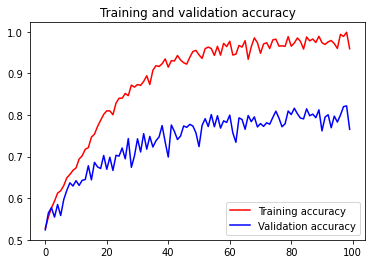

<Figure size 432x288 with 0 Axes>

In [28]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [29]:
y_test

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [30]:
y_test_labels=[np.argmax(i) for i in y_test]
y_test_labels[:5]

[2, 2, 3, 3, 0]

In [31]:
X_test_labels=[np.argmax(i) for i in X_test]
X_test_labels[:5]

[100083, 129735, 106272, 115413, 159528]

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math as math
from pylab import rcParams

In [35]:
class_labels=["mild","moderate","no","verymild"]
  

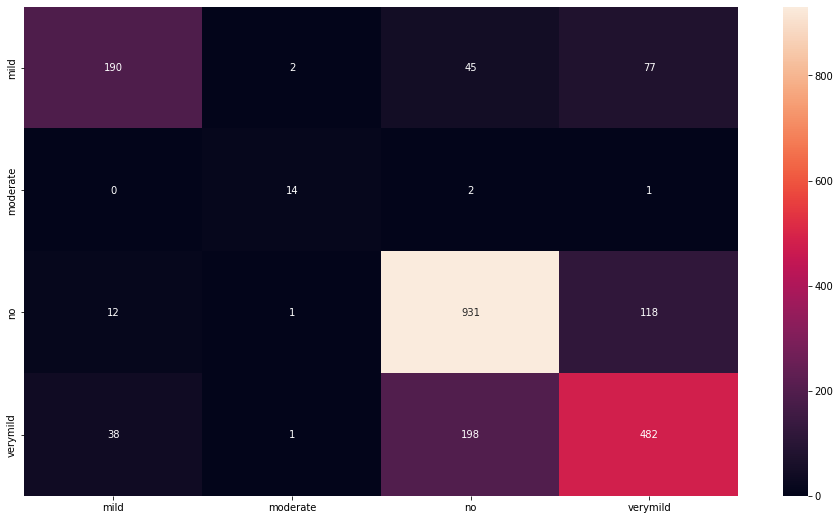

In [36]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(16,9))
cm=confusion_matrix(y_test_labels,ind)
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_labels, yticklabels=class_labels)

In [37]:
from sklearn.metrics import classification_report
cr=classification_report(y_test_labels,ind,target_names=class_labels)
print (cr)

              precision    recall  f1-score   support

        mild       0.79      0.61      0.69       314
    moderate       0.78      0.82      0.80        17
          no       0.79      0.88      0.83      1062
    verymild       0.71      0.67      0.69       719

    accuracy                           0.77      2112
   macro avg       0.77      0.74      0.75      2112
weighted avg       0.76      0.77      0.76      2112

